# DBSCAN - Density Based Spatial Clustering of Applications with Noise

## Use cases:
- monitoring hot spots
- finding densed clusterd
- identify outliers

In [31]:
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
import myenvvar
from sklearn.cluster import DBSCAN
import datetime as dt
from sklearn.neighbors import NearestNeighbors

In [2]:
conn = MySQLdb.Connection(
        host=myenvvar.db_vars['host'],
        user=myenvvar.db_vars['user'],
        passwd=myenvvar.db_vars['password'],
        port=myenvvar.db_vars['port'],
        db=myenvvar.db_vars['db']
        )

In [24]:
q = "SELECT * FROM audio_features"
audio_features_df = pd.read_sql(q, conn)

In [25]:
audio_features_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,total_available_markets,popularity,added_datetime
0,00bOhb4584JjyfTiXX81mO,0.629,0.387,10,-13.667,1,0.0386,0.42400,0.0000,0.0479,0.497,76.003,275640,4,79,58,2020-06-06 16:50:49
1,00FldKRY0RvsKorwsMzNt3,0.605,0.856,2,-6.094,0,0.0666,0.03460,0.8730,0.0874,0.215,152.005,202105,4,79,37,2020-06-06 16:50:49
2,00HqKJWFv3GS9cPfEB1WQm,0.678,0.795,4,-6.309,0,0.1310,0.01010,0.0159,0.0981,0.648,118.006,215593,4,79,55,2020-06-10 08:09:43
3,00KCwnrvIXX8GRU3ZMOIBW,0.825,0.692,6,-6.084,0,0.0627,0.17200,0.0010,0.0861,0.602,123.985,207821,4,2,61,2020-06-12 08:44:13
4,00VpefDueq3OB9zkZHLDVI,0.636,0.963,7,-7.309,1,0.0636,0.00342,0.1940,0.1130,0.766,124.971,216025,4,2,26,2020-06-08 07:47:57


# drop columns and scale features

In [26]:
cols_to_drop = ['key', 'time_signature', 'total_available_markets', 'mode', 'duration_ms','popularity','added_datetime']
audio_features_df = audio_features_df.drop(cols_to_drop,axis=1)

In [27]:
for col in ['loudness', 'tempo']:
    audio_features_df[col] = ((audio_features_df[col] - audio_features_df[col].min()) / (audio_features_df[col].max() - audio_features_df[col].min()))

In [29]:
audio_features_df.set_index('track_id',inplace=True)
audio_features_df.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_id,,,,,,,,,
00bOhb4584JjyfTiXX81mO,0.629,0.387,0.482140,0.0386,0.42400,0.0000,0.0479,0.497,0.219707
00FldKRY0RvsKorwsMzNt3,0.605,0.856,0.739271,0.0666,0.03460,0.8730,0.0874,0.215,0.631622
00HqKJWFv3GS9cPfEB1WQm,0.678,0.795,0.731971,0.1310,0.01010,0.0159,0.0981,0.648,0.447355
00KCwnrvIXX8GRU3ZMOIBW,0.825,0.692,0.739610,0.0627,0.17200,0.0010,0.0861,0.602,0.479760
00VpefDueq3OB9zkZHLDVI,0.636,0.963,0.698017,0.0636,0.00342,0.1940,0.1130,0.766,0.485104


# Finding the optimal epsilon for DBSCAN algorithm

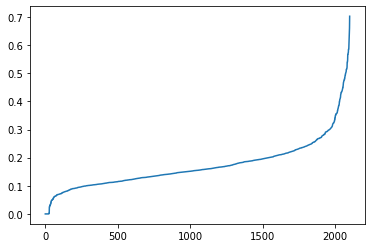

In [32]:
neigh = NearestNeighbors(n_neighbors=2,metric='euclidean')
nbrs = neigh.fit(audio_features_df)
distances, indices = nbrs.kneighbors(audio_features_df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

# Pairplot tracks features and clusters centroids for DBSCAN clustering
The purpose of this section is to show the connection between each pair features and the resulting clusters

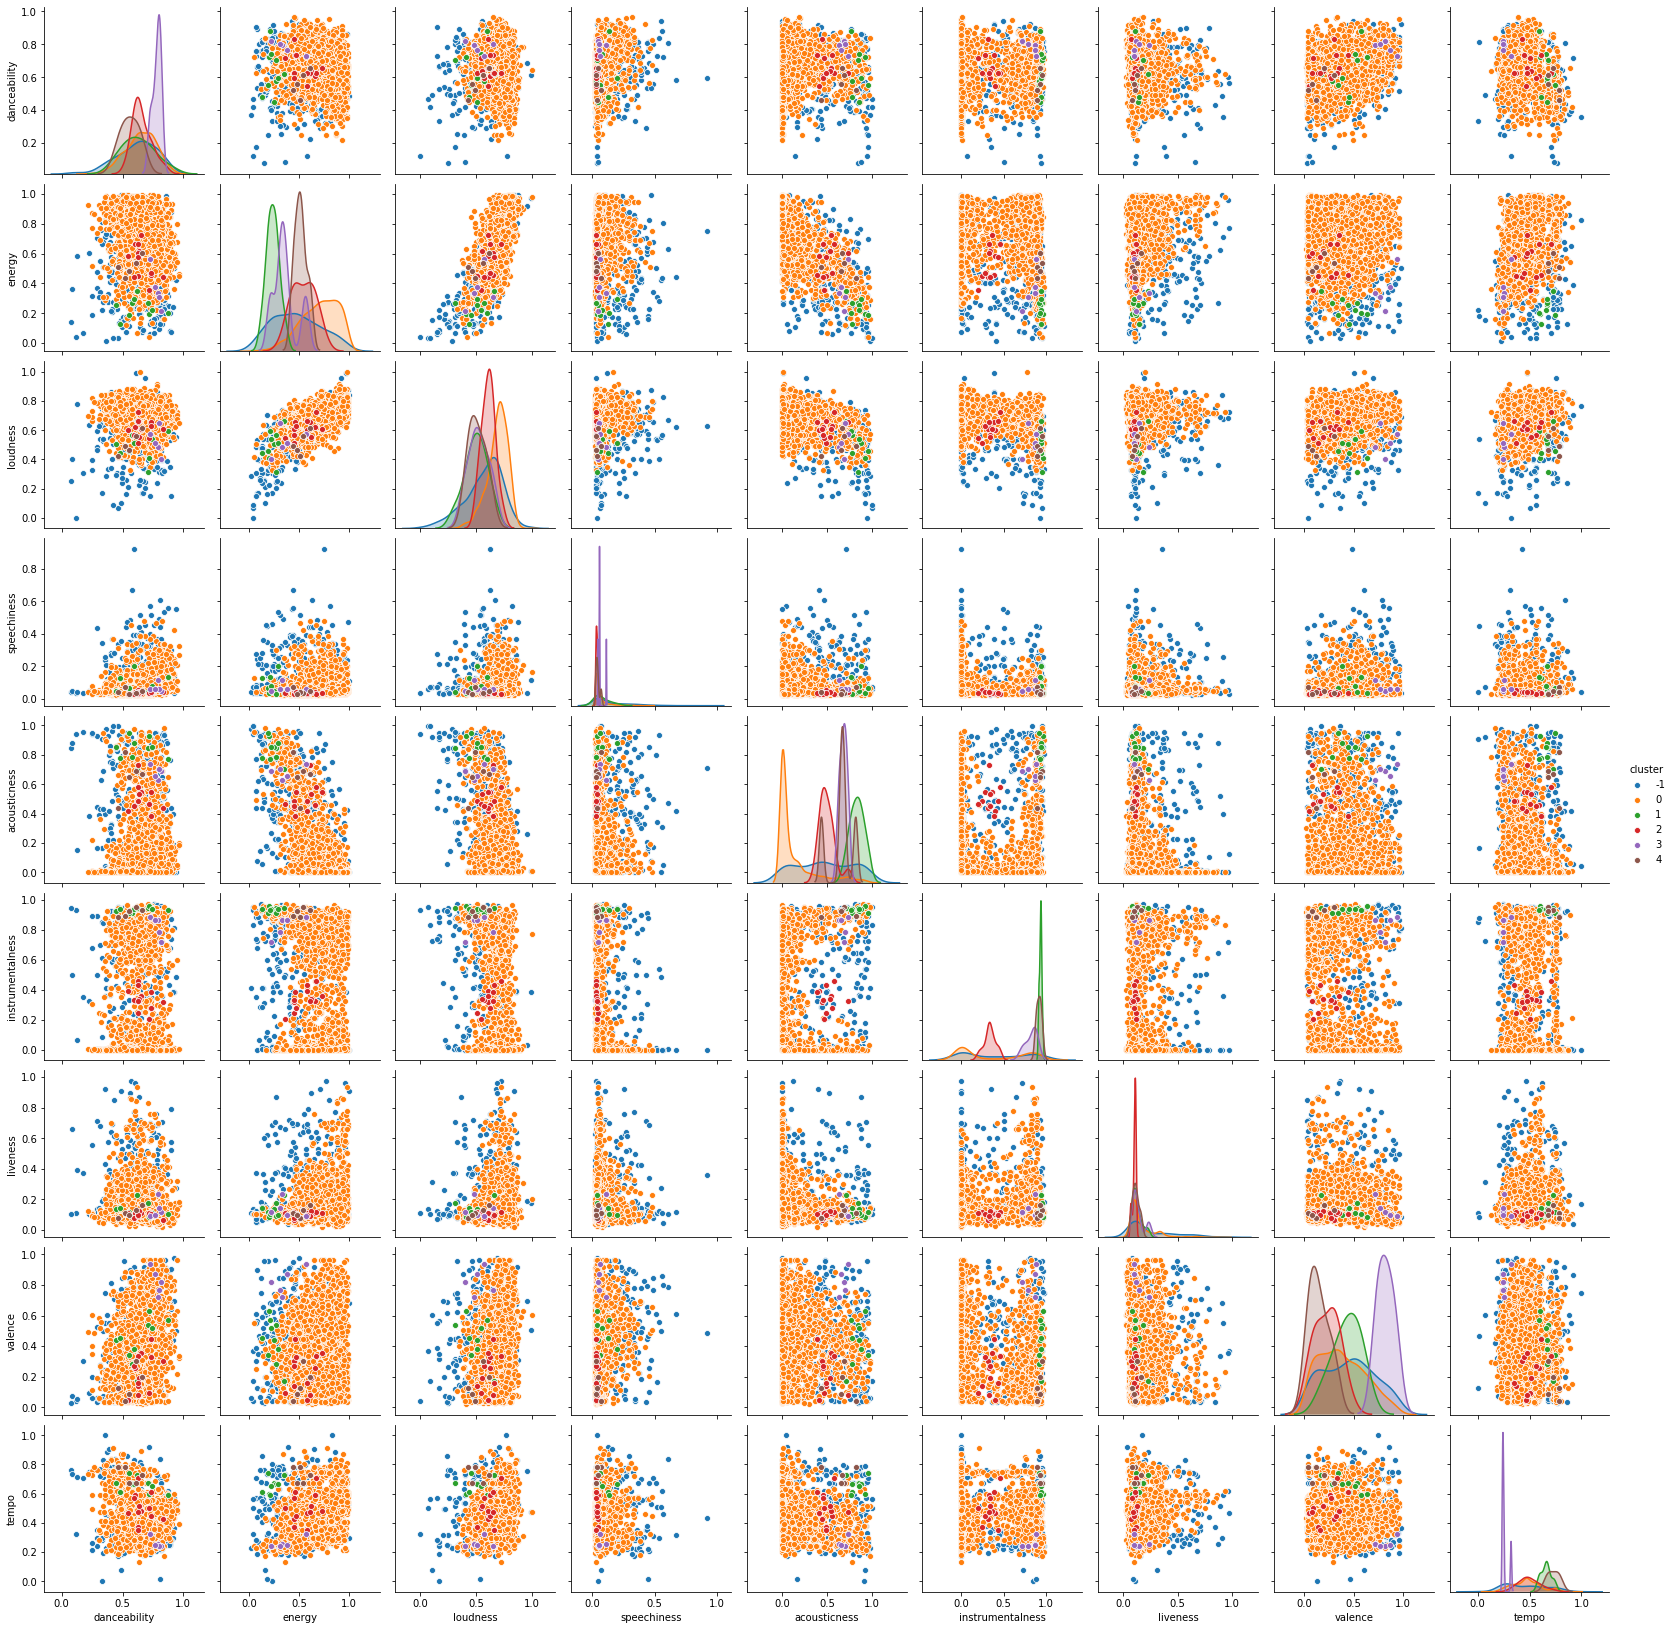

In [35]:
dbscan_model = DBSCAN(eps=0.27,min_samples=5).fit(audio_features_df)
audio_features_df['cluster'] = dbscan_model.labels_
sns.pairplot(audio_features_df,hue='cluster')